In [1]:
cd(@__DIR__)
using Pkg
Pkg.activate(".")

  Activating project at `~/Teaching/nn-zero-to-hero/julia/Makemore`


In [18]:
# Pkg.add("OneHotArrays")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/Teaching/nn-zero-to-hero/julia/Makemore/Project.toml`
  [0b1bfda6] + OneHotArrays v0.2.3
  No Changes to `~/Teaching/nn-zero-to-hero/julia/Makemore/Manifest.toml`


In [22]:
# Pkg.add("ProgressMeter")

   Resolving package versions...
    Updating `~/Teaching/nn-zero-to-hero/julia/Makemore/Project.toml`
  [92933f4c] + ProgressMeter v1.7.2
    Updating `~/Teaching/nn-zero-to-hero/julia/Makemore/Manifest.toml`
  [92933f4c] + ProgressMeter v1.7.2


In [19]:
begin
    using Flux
    using Zygote
    using Random
    using Distributions
    using Plots
    using StatsBase
    using Statistics
end

In [3]:
begin
    data_url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    dat = download(data_url)
end;

In [5]:
words = readlines(dat; keep=false);

In [7]:
begin
    # chars = collect('a':'z')
    chars = sort(unique(join(words)))
    num_chars = length(chars) 
    # push!(chars, '.')
    insert!(chars, 1, '.')
    stoi = Dict(zip(chars, 1:length(chars)))
    itos = Dict(zip(1:length(chars), chars))
end;

In [9]:
begin
    N = zeros(Int32, length(chars), length(chars))
    for w in words
        w = "." * w * "."
        for i in 1:(length(w)-1)
            N[stoi[w[i]], stoi[w[i+1]]] += 1
        end
    end

    N_smoothed = N .+ 1
end

27×27 Matrix{Int64}:
    1  4411  1307  1543  1691  1532  …  1309   79  377  308  135   536  930
 6641   557   542   471  1043   693      688  382  835  162  183  2051  436
  115   322    39     2    66   656        3   46    1    1    1    84    1
   98   816     1    43     2   552       36   36    1    1    4   105    5
  517  1304     2     4   150  1284        5   93   18   24    1   318    2
 3984   680   122   154   385  1272  …   581   70  464   51  133  1071  182
   81   243     1     1     1   124       19   11    1    5    1    15    3
  109   331     4     1    20   335       32   86    2   27    1    32    2
 2410  2245     9     3    25   675       72  167   40   11    1   214   21
 2490  2446   111   510   441  1654      542  110  270    9   90   780  278
   72  1474     2     5     5   441  …     3  203    6    7    1    11    1
  364  1732     3     3     3   896       18   51    3   35    1   380    3
 1315  2624    53    26   139  2922       78  325   73   17    1  1

In [10]:
P = N_smoothed ./ sum(N_smoothed, dims=2)

27×27 Matrix{Float64}:
 3.11915e-5  0.137586   0.0407673    0.0481285    …  0.0167187   0.0290081
 0.19583     0.0164249  0.0159825    0.0138889       0.0604801   0.0128568
 0.0430389   0.120509   0.0145958    0.000748503     0.0314371   0.000374251
 0.0275358   0.229278   0.000280978  0.012082        0.0295027   0.00140489
 0.0936085   0.236104   0.000362122  0.000724244     0.0575774   0.000362122
 0.194817    0.0332518  0.00596577   0.00753056   …  0.0523716   0.00889976
 0.0869099   0.26073    0.00107296   0.00107296      0.0160944   0.00321888
 0.055783    0.169396   0.00204708   0.000511771     0.0163767   0.00102354
 0.315321    0.293733   0.00117755   0.000392516     0.0279995   0.00274761
 0.140456    0.137974   0.00626128   0.0287681       0.0439982   0.0156814
 0.0245986   0.503587   0.000683293  0.00170823   …  0.00375811  0.000341647
 0.0718374   0.34182    0.000592066  0.000592066     0.0749951   0.000592066
 0.0940293   0.18763    0.00378977   0.00185913      0.113622   

In [11]:
begin
    # flip along y axis
    N_prime = zeros(Int, 27, 27)
    for i in 1:27, j in 1:27
        N_prime[i, j] = N[27 - i + 1, j]
    end
end;

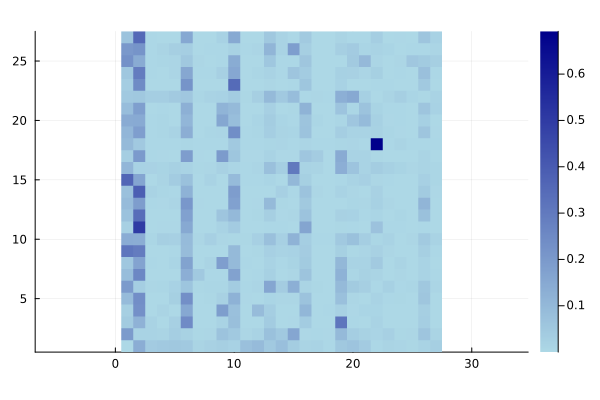

In [85]:
heatmap(1:27, 1:27, P, color=:blues, aspect_ratio=1) 

In [13]:
let
    Random.seed!(4321)
    num_names = 5
    names = Array{String}(undef, num_names)
    for i in 1:num_names
        # sample bi-grams
        c = '.'
        ci = stoi[c] 
        name = "."
        while true
            ci = sample(Weights(P[stoi[c], :]))
            c = itos[ci]
            name = name * c
            if c == '.'
                break
            end
        end
        names[i] = name
    end
    names
end

5-element Vector{String}:
 ".kat."
 ".aios."
 ".h."
 ".ki."
 ".mckhamberckhestha."

In [14]:
using Printf

In [15]:
let
    log_likelihood = 0.0
    logP = log.(P)
    n = 0
    for w in words
        w = "." * w * "."
        for i in 1:(length(w)-1)
            # N[stoi[w[i]], stoi[w[i+1]]] += 1
            log_likelihood += logP[stoi[w[i]], stoi[w[i+1]]]
            n += 1
        end
    end
    # log_likelihood, -log_likelihood / n
    @printf "nll: %.4f\n" -log_likelihood
    @printf "nll avg: %.4f\n" -log_likelihood/n
end

nll: 560001.8832
nll avg: 2.4546


In [20]:
using OneHotArrays

In [23]:
using Statistics, ProgressMeter

In [25]:
begin
    train_x = []
    train_y = []
    for w in words
        w = "." * w * "."
        for i in 1:(length(w)-1)
            push!(train_x, stoi[w[i]])
            push!(train_y, stoi[w[i+1]])
        end
    end
    train_x, train_y
end

(Any[1, 6, 14, 14, 2, 1, 16, 13, 10, 23  …  26, 19, 16, 15, 1, 27, 27, 26, 27, 25], Any[6, 14, 14, 2, 1, 16, 13, 10, 23, 10  …  19, 16, 15, 1, 27, 27, 26, 27, 25, 1])

In [27]:
onehotbatch(train_x, 1:27);

In [28]:
begin
    target = onehotbatch(train_y, 1:27)                   
    train_xs = onehotbatch(train_x, 1:27) 
end

27×228146 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  …  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅

In [130]:
loader = Flux.DataLoader((train_xs, target), batchsize=5000, shuffle=true);

In [131]:
# begin
#     pen_l2(x)::Float32 = sum(abs2, x)
#     model = Dense(27=>27, bias=false)
#     optim = Flux.setup(Flux.Adam(0.01), model) 
#     losses = []
#     # for epoch in 1:1
#     for epoch in 1:10
#         for (x, y) in loader
#             @time loss, grads = Flux.withgradient(model) do m
#                 yhat = m(x)
#                 loss = Flux.crossentropy(yhat, y) + 0.01f0 * sum(abs2, m[1].weight)
#                 # loss = Flux.crossentropy(yhat, y) + 
#                 # 0.01f0 * sum(abs2, m[1].weight)
# #                 0.01f0 * sum(pen_l2, Flux.params(m))
#                 # + 0.1f0 * sum(abs2, Flux.params(m[1])[1])
#                 # penalty = 0.01f0 * sum(pen_l2, Flux.params(m))
#                 # loss = loss + penalty
#             end
#             Flux.update!(optim, model, grads[1])
#             push!(losses, loss)
#         end
#     end
# end

In [137]:
begin
    pen_l2(x)::Float32 = sum(abs2, x)
    model = Dense(27=>27, bias=false)
    optim = Flux.setup(Flux.Descent(10), model) 
    losses = []
    @showprogress for epoch in 1:100
        for (x, y) in loader
            loss, grads = Flux.withgradient(model) do m
                yhat = m(x)
                loss = Flux.logitcrossentropy(yhat, y) + 0.01f0 * mean(abs2, m.weight)
            end
            Flux.update!(optim, model, grads[1])
            push!(losses, loss)
        end
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:08


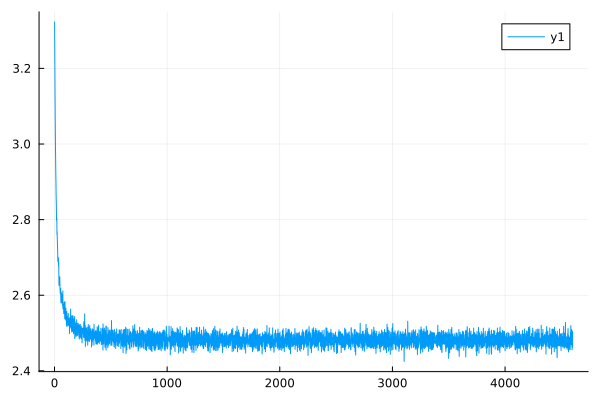

In [138]:
plot(losses)

In [139]:
losses

4600-element Vector{Any}:
 3.3227265f0
 3.2710195f0
 3.2194424f0
 3.1794221f0
 3.123077f0
 3.080862f0
 3.0490322f0
 3.0141623f0
 2.9856148f0
 2.9636102f0
 2.9381468f0
 2.9153662f0
 2.8971589f0
 ⋮
 2.49413f0
 2.4713175f0
 2.509149f0
 2.486368f0
 2.4789302f0
 2.467146f0
 2.4554415f0
 2.482045f0
 2.5052743f0
 2.4621248f0
 2.4658875f0
 2.5024505f0

In [140]:
softmax(model(train_xs[:, 1]))

27-element Vector{Float32}:
 0.0006857991
 0.13899828
 0.04199843
 0.049004145
 0.052254055
 0.047691837
 0.013279741
 0.020430023
 0.027419133
 0.018322935
 0.07422136
 0.0932691
 0.05117051
 ⋮
 0.0124314865
 0.016359646
 0.0032571363
 0.04922769
 0.061923373
 0.03974387
 0.0028405837
 0.0119773885
 0.009690101
 0.004477001
 0.016707098
 0.029395513

In [141]:
P[onecold(train_xs[1,:]),:]

27-element Vector{Float64}:
 3.1191515907673116e-5
 0.1375857766687461
 0.04076731129132876
 0.048128509045539614
 0.05274485339987523
 0.04778540237055521
 0.013038053649407362
 0.020898315658140987
 0.027292576419213975
 0.01846537741734248
 0.07557704304429196
 0.09245165315034311
 0.04906425452276981
 ⋮
 0.012320648783530879
 0.016094822208359325
 0.0029008109794135995
 0.051154086088583905
 0.06412975670617592
 0.0408296943231441
 0.002464129756706176
 0.011759201497192763
 0.00960698689956332
 0.00421085464753587
 0.01671865252651279
 0.029008109794135994

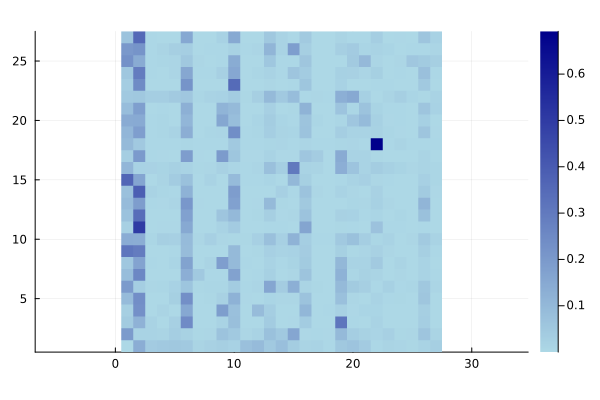

In [143]:
heatmap(1:27, 1:27, P, color=:blues, aspect_ratio=1) 

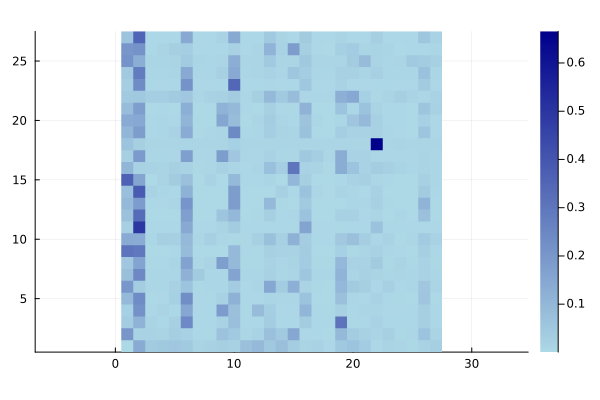

In [148]:
heatmap(1:27, 1:27, softmax(model.weight, dims=1)', color=:blues, aspect_ratio=1) 